# MNIST - NN - PyTorch

- [Сургалтанд шаардлагатай зүйлс](#Сургалтанд-шаардлагатай-зүйлс)
    * [Сургалтын өгөгдөл унших](#Сургалтын-өгөгдөл-унших)
    * [Accuracy тооцоолох функц](#Accuracy-тооцоолох-функц)
    * [Сургалт явуулах ерөнхий функц](#Сургалт-явуулах-ерөнхий-функц)
- [Сургалт](#Сургалт)
    * [1. Энгийн Neural Network](#1.-Энгийн-Neural-Network)
    * [2. Энгийн Neural Network (sigmoid)](#2.-Энгийн-Neural-Network-(sigmoid))
    * [3. Олон давхаргатай Neural Network](#3.-Олон-давхаргатай-Neural-Network)
    * [4. Neural Network with Dropout](#4.-Neural-Network-with-Dropout)

In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Сургалтанд шаардлагатай зүйлс

### Сургалтын өгөгдөл унших

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])

batch_size = 150
valid_size = 0.2

trainset = datasets.MNIST('.', download=False, train=True, transform=transform)
testset = datasets.MNIST('.', download=False, train=False, transform=transform)

# Training өгөгдлөөс Validation өгөгдлийг ялгаж авах
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

batch_count = len(trainloader)
print('Сургах өгөгдөл (Training data):', len(train_idx))
print('Үнэлэх өгөгдөл (Validation data):', len(valid_idx))
print('Шалгах өгөгдөл (Test data):', len(testset))
print('Batch тоо:', batch_count)

Сургах өгөгдөл (Training data): 48000
Үнэлэх өгөгдөл (Validation data): 12000
Шалгах өгөгдөл (Test data): 10000
Batch тоо: 320


### Нарийвчлал тооцоолох функц

In [3]:
def get_accuracy(predicted, target):
    equals = predicted.max(1)[1] == target
    return torch.mean(equals.type(torch.FloatTensor)).item()

### Сургалт явуулах ерөнхий функц

**Параметрууд**
- `model` - сургах модель
- `criterion` - loss функц
- `optimizer` - optimizer
- `epoch` - epoch тоо
- `save_file_name` - validation loss хамгийн бага үеийн утгуудыг хадгалах файлын нэр

**Буцаах утга**
- `model` - сургасан модель
- `train_losses` - сургалтын өгөгдлийн loss
- `valid_losses` - үнэлгээний өгөгдлийн loss

In [4]:
def train(model, criterion, optimizer, epoch, save_file_name='model.pt'):
    train_losses, valid_losses = [], []
    
    valid_loss_min = np.Inf

    for e in range(epoch):
        batch_n = 1
        batch_mean_loss = 0
        batch_mean_accuracy = 0
        print(f'Epoch: {e+1}/{epoch}')

        for images, labels in trainloader:
            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            batch_mean_loss += loss.item()
            batch_mean_accuracy += get_accuracy(log_ps, labels)

            helper.print_progress(batch_n, batch_count, bar_len=45, loss=batch_mean_loss/batch_n, accuracy=batch_mean_accuracy*(100/batch_n))
            batch_n += 1
        else:
            valid_loss = 0
            valid_accuracy = 0
            with torch.no_grad():
                model.eval()
                for images, labels in validloader:
                    log_ps = model(images)
                    valid_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    valid_accuracy += get_accuracy(ps, labels)
            model.train()
            
            valid_loss /= len(validloader)
            valid_accuracy /= len(validloader)
            
            train_losses.append(batch_mean_loss/len(trainloader))
            valid_losses.append(valid_loss)

            print("\n\tTraining Loss: {:.3f}.. ".format(batch_mean_loss/len(trainloader)),
                  "Validation Loss: {:.3f}.. ".format(valid_loss),
                  "Validation Accuracy: {:.3f}%".format(valid_accuracy*100))
            
            if valid_loss_min > valid_loss:
                print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...\n'.format(valid_loss_min,valid_loss))
                torch.save(model.state_dict(), save_file_name)
                valid_loss_min = valid_loss
    return model, train_losses, valid_losses

### Шалгах функц

**Параметрууд**
- `model` - сургасан модель

**Буцаах утга**
- `test_accuracy` - шалгалтын өгөгдлийг зөв таньсан хувь
- `test_loss` - шалгалтын өгөгдлийн loss

In [5]:
def test(model):
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            test_accuracy += get_accuracy(ps, labels)
    model.train()

    test_loss /= len(testloader)
    test_accuracy /= len(testloader)
    return test_accuracy, test_loss

## Сургалт

### 1. Энгийн Neural Network

1 Hidden Layer

**Model:** `Input(784)` **\>** `Linear(160)` **\>** `ReLU` **\>** `Linear(10)` **\>** `Softmax`

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [24]:
# Оролт
input_size = 784
# Нуугдмал давхарга
hidden_size = 160
# Гаралт
output_size = 10

In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [26]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [27]:
save_name = 'model1.pt'
model, train_losses, valid_losses = train(model, criterion, optimizer, epoch=15, save_file_name=save_name)

Epoch: 1/15
[=============================================] 100.0% 320/320 loss*: 0.388 accuracy*: 88.763%
	Training Loss: 0.388..  Validation Loss: 0.197..  Validation Accuracy: 94.208%
	Validation loss decreased (inf --> 0.197177).  Saving model ...

Epoch: 2/15
[=============================================] 100.0% 320/320 loss*: 0.147 accuracy*: 95.748%
	Training Loss: 0.147..  Validation Loss: 0.128..  Validation Accuracy: 96.400%
	Validation loss decreased (0.197177 --> 0.127556).  Saving model ...

Epoch: 3/15
[=============================================] 100.0% 320/320 loss*: 0.103 accuracy*: 96.973%
	Training Loss: 0.103..  Validation Loss: 0.108..  Validation Accuracy: 96.767%
	Validation loss decreased (0.127556 --> 0.107565).  Saving model ...

Epoch: 4/15
[=============================================] 100.0% 320/320 loss*: 0.076 accuracy*: 97.821%
	Training Loss: 0.076..  Validation Loss: 0.101..  Validation Accuracy: 96.842%
	Validation loss decreased (0.107565 --> 0.1

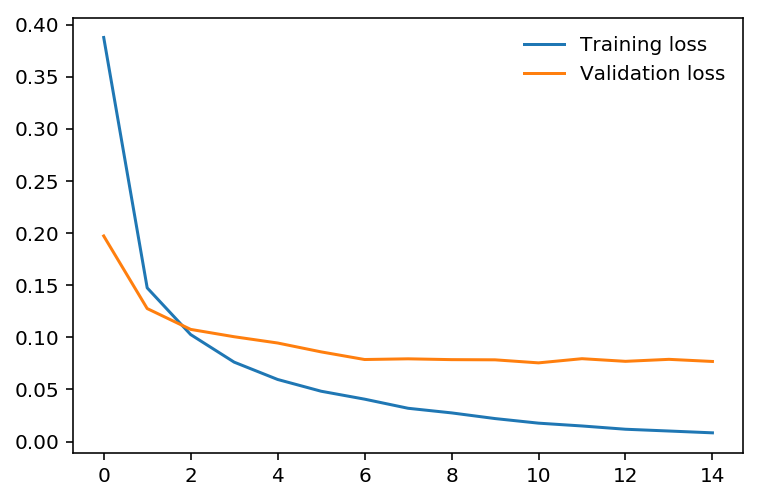

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [29]:
# Хадгалсан утгуудаа унших
model.load_state_dict(torch.load(save_name))
# Шалгах
test_accuracy, test_loss = test(model)
print('Test Accuracy: {:.3f}%'.format(test_accuracy*100))
print('Test Loss: {:.3f}'.format(test_loss))

Test Accuracy: 97.915%
Test Loss: 0.070


### 2. Энгийн Neural Network (sigmoid)

1 Hidden Layer

**Model:** `Input(784)` **\>** `Linear(160)` **\>** `Sigmoid` **\>** `Linear(10)` **\>** `Softmax`

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [30]:
# Оролт
input_size = 784
# Нуугдмал давхарга
hidden_size = 160
# Гаралт
output_size = 10

In [31]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [32]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [33]:
model, train_losses, valid_losses = train(model, criterion, optimizer, epoch=15, save_file_name='model2.pt')

Epoch: 1/15
[=============================================] 100.0% 320/320 loss*: 0.665 accuracy*: 80.667%
	Training Loss: 0.665..  Validation Loss: 0.324..  Validation Accuracy: 90.483%
	Validation loss decreased (inf --> 0.323565).  Saving model ...

Epoch: 2/15
[=============================================] 100.0% 320/320 loss*: 0.299 accuracy*: 91.290%
	Training Loss: 0.299..  Validation Loss: 0.276..  Validation Accuracy: 92.042%
	Validation loss decreased (0.323565 --> 0.275764).  Saving model ...

Epoch: 3/15
[=============================================] 100.0% 320/320 loss*: 0.253 accuracy*: 92.575%
	Training Loss: 0.253..  Validation Loss: 0.244..  Validation Accuracy: 92.917%
	Validation loss decreased (0.275764 --> 0.244201).  Saving model ...

Epoch: 4/15
[=============================================] 100.0% 320/320 loss*: 0.219 accuracy*: 93.698%
	Training Loss: 0.219..  Validation Loss: 0.219..  Validation Accuracy: 93.508%
	Validation loss decreased (0.244201 --> 0.2

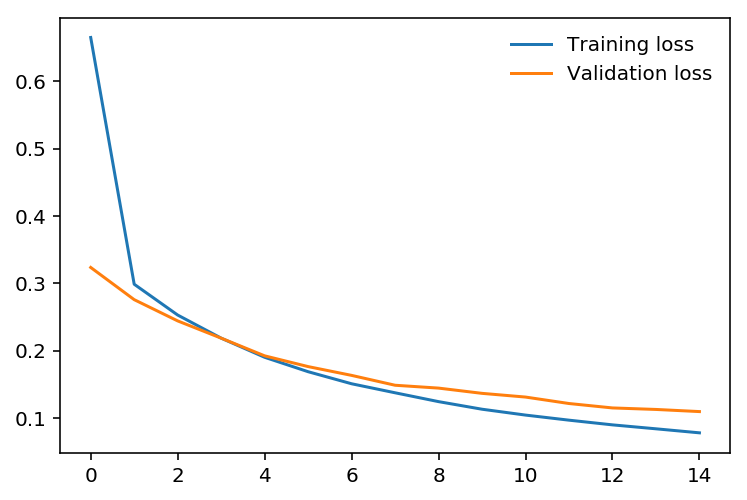

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [35]:
# Хадгалсан утгуудаа унших
model.load_state_dict(torch.load('model2.pt'))
# Шалгах
test_accuracy, test_loss = test(model)
print('Test Accuracy: {:.3f}%'.format(test_accuracy*100))
print('Test Loss: {:.3f}'.format(test_loss))

Test Accuracy: 96.896%
Test Loss: 0.100


### 3. Олон давхаргатай Neural Network

2 Hidden Layer

**Model:** `Input(784)` **\>** `Linear(360)` **\>** `ReLU` **\>** `Linear(120)` **\>** `ReLU` **\>** `Linear(10)` **\>** `Softmax`

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [36]:
input_size = 784
hidden_sizes = [360, 120]
output_size = 10

In [37]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                    nn.ReLU(),
                                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                    nn.ReLU(),
                                    nn.Linear(hidden_sizes[1], output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [38]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.06, momentum=0.9)

In [39]:
model, train_losses, valid_losses = train(model, criterion, optimizer, epoch=15, save_file_name='model3.pt')

Epoch: 1/15
[=============================================] 100.0% 320/320 loss*: 0.457 accuracy*: 86.298%
	Training Loss: 0.457..  Validation Loss: 0.163..  Validation Accuracy: 95.300%
	Validation loss decreased (inf --> 0.163265).  Saving model ...

Epoch: 2/15
[=============================================] 100.0% 320/320 loss*: 0.130 accuracy*: 96.129%
	Training Loss: 0.130..  Validation Loss: 0.116..  Validation Accuracy: 96.417%
	Validation loss decreased (0.163265 --> 0.116223).  Saving model ...

Epoch: 3/15
[=============================================] 100.0% 320/320 loss*: 0.084 accuracy*: 97.438%
	Training Loss: 0.084..  Validation Loss: 0.104..  Validation Accuracy: 96.725%
	Validation loss decreased (0.116223 --> 0.103850).  Saving model ...

Epoch: 4/15
[=============================================] 100.0% 320/320 loss*: 0.062 accuracy*: 98.067%
	Training Loss: 0.062..  Validation Loss: 0.083..  Validation Accuracy: 97.617%
	Validation loss decreased (0.103850 --> 0.0

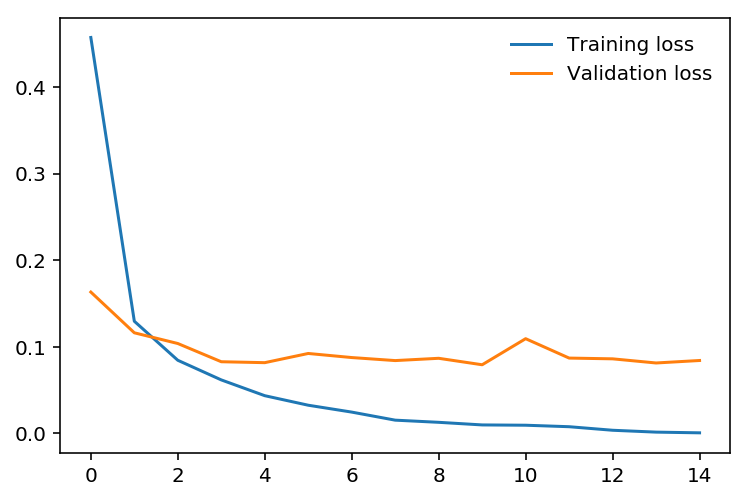

In [40]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [41]:
# Хадгалсан утгуудаа унших
model.load_state_dict(torch.load('model3.pt'))
# Шалгах
test_accuracy, test_loss = test(model)
print('Test Accuracy: {:.3f}%'.format(test_accuracy*100))
print('Test Loss: {:.3f}'.format(test_loss))

Test Accuracy: 98.020%
Test Loss: 0.072


### 4. Neural Network with Dropout

2 Hidden Layer + Dropout

**Model:** `Input(784)` **\>** `Linear(360)` **\>** `ReLU` **\>** `Dropout(0.2)` **\>** `Linear(120)` **\>** `ReLU` **\>** `Dropout(0.2)` **\>** `Linear(10)` **\>** `Softmax`

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [42]:
input_size = 784
hidden_sizes = [360, 120]
output_size = 10

In [43]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_sizes[1], output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [44]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [45]:
model, train_losses, valid_losses = train(model, criterion, optimizer, epoch=15, save_file_name='model4.pt')

Epoch: 1/15
[=============================================] 100.0% 320/320 loss*: 0.454 accuracy*: 86.240%
	Training Loss: 0.454..  Validation Loss: 0.167..  Validation Accuracy: 94.817%
	Validation loss decreased (inf --> 0.167160).  Saving model ...

Epoch: 2/15
[=============================================] 100.0% 320/320 loss*: 0.157 accuracy*: 95.369%
	Training Loss: 0.157..  Validation Loss: 0.109..  Validation Accuracy: 96.742%
	Validation loss decreased (0.167160 --> 0.109347).  Saving model ...

Epoch: 3/15
[=============================================] 100.0% 320/320 loss*: 0.111 accuracy*: 96.635%
	Training Loss: 0.111..  Validation Loss: 0.098..  Validation Accuracy: 97.108%
	Validation loss decreased (0.109347 --> 0.098235).  Saving model ...

Epoch: 4/15
[=============================================] 100.0% 320/320 loss*: 0.087 accuracy*: 97.323%
	Training Loss: 0.087..  Validation Loss: 0.090..  Validation Accuracy: 97.267%
	Validation loss decreased (0.098235 --> 0.0

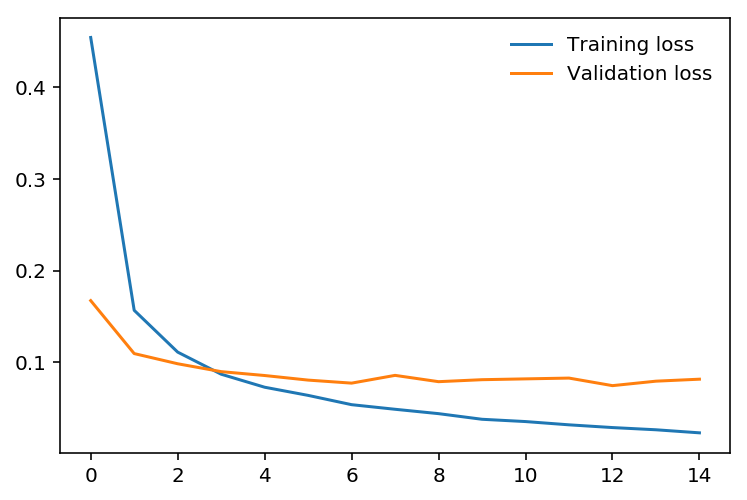

In [46]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [47]:
# Хадгалсан утгуудаа унших
model.load_state_dict(torch.load('model4.pt'))
# Шалгах
test_accuracy, test_loss = test(model)
print('Test Accuracy: {:.3f}%'.format(test_accuracy*100))
print('Test Loss: {:.3f}'.format(test_loss))

Test Accuracy: 98.189%
Test Loss: 0.065
